In [1]:
# Following Libraries are being used
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import time
import statsmodels.api as sm
from sklearn import linear_model #For missing values
from sklearn.preprocessing import StandardScaler #For scaling features

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression #Linear Regressor

In [2]:
data=pd.read_csv("googleplaystore.csv")

In [3]:
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [4]:
# Checking Dimensions of the Data
data.shape

(10841, 13)

In [5]:
# Explore Columns
data.columns

Index(['App', 'Category', 'Rating', 'Reviews', 'Size', 'Installs', 'Type',
       'Price', 'Content Rating', 'Genres', 'Last Updated', 'Current Ver',
       'Android Ver'],
      dtype='object')

In [6]:
# Description
data.describe()

,Rating
count,9367.000000
mean,4.193338
std,0.537431
min,1.000000
25%,4.000000
50%,4.300000
75%,4.500000
max,19.000000


In [7]:
# Check Datatypes
data.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [8]:
# Drop the Columns which have no Impact
data = data.drop(columns=['App', 'Last Updated', 'Current Ver', 'Android Ver'])

In [9]:
# Check Missing Values in each column of Training Data
data.isnull().sum()

Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
dtype: int64

In [10]:
# Check if any of the record has rating > 5
data[data['Rating'] > 5]

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
10472,1.9,19.0,3.0M,"1,000+",Free,0,Everyone,NaN,"February 11, 2018"


In [11]:
# Now check if 1.9 is the real category or its a dummy data
data['Category'].unique().tolist()

['ART_AND_DESIGN',
 'AUTO_AND_VEHICLES',
 'BEAUTY',
 'BOOKS_AND_REFERENCE',
 'BUSINESS',
 'COMICS',
 'COMMUNICATION',
 'DATING',
 'EDUCATION',
 'ENTERTAINMENT',
 'EVENTS',
 'FINANCE',
 'FOOD_AND_DRINK',
 'HEALTH_AND_FITNESS',
 'HOUSE_AND_HOME',
 'LIBRARIES_AND_DEMO',
 'LIFESTYLE',
 'GAME',
 'FAMILY',
 'MEDICAL',
 'SOCIAL',
 'SHOPPING',
 'PHOTOGRAPHY',
 'SPORTS',
 'TRAVEL_AND_LOCAL',
 'TOOLS',
 'PERSONALIZATION',
 'PRODUCTIVITY',
 'PARENTING',
 'WEATHER',
 'VIDEO_PLAYERS',
 'NEWS_AND_MAGAZINES',
 'MAPS_AND_NAVIGATION',
 '1.9']

In [12]:
# So its obvious that 1.9 category and rating 
# above 5 doesn't make sense, so drop this record
rec = data[data['Category'] == '1.9'].index
data = data.drop(rec)

In [13]:
# Make a copy of data
train_data = data.copy()

In [14]:
# Cleaning "Price" column
train_data['Price'] = train_data['Price'].apply(lambda x : x.strip('$'))

In [15]:
# Cleaning "Installs" column
train_data['Installs'] = train_data['Installs'].apply(lambda x : x.strip('+').replace(',', ''))

In [16]:
# Convert all these to float
train_data['Price'] = train_data['Price'].astype(float)
train_data['Installs'] = train_data['Installs'].astype(float)
train_data['Reviews'] = train_data['Reviews'].astype(float)

In [17]:
# Remove record with Type nan
rec = train_data[train_data['Type'].isnull()].index
train_data = train_data.drop(rec)

In [18]:
# Get all features with type 'object'
col_list = [c for c in train_data.columns if train_data[c].dtype == 'object']
col_list

['Category', 'Size', 'Type', 'Content Rating', 'Genres']

In [19]:
# Encode features except Size
for c in col_list:
    if c != 'Size':
        train_data[c] = train_data[c].astype('category')
        train_data[c] = train_data[c].cat.codes #categorizing variables into numbers

In [20]:
# Compare actual and encoded labels for column 'Type'
print(data['Type'].unique().tolist())
print(train_data['Type'].unique().tolist(), '\n')

['Free', 'Paid', nan]
[0, 1] 



In [21]:
# Replace "Varies with device" in Size with null value
train_data.loc[train_data['Size'] == 'Varies with device', 'Size'] = np.nan

In [22]:
# Removing the suffixes (k and M) and representing all the data as bytes 
# (i.e)for k, value is multiplied by 1000 and for M, the value is multiplied by 1000000 
train_data.Size = (train_data.Size.replace(r'[kM]+$', '', regex=True).astype(float) * \
             train_data.Size.str.extract(r'[\d\.]+([KM]+)', expand=False).fillna(1)
            .replace(['k','M'], [10**3, 10**6]).astype(int))

In [23]:
# Now check null values
train_data.isnull().sum()

Category             0
Rating            1473
Reviews              0
Size              1694
Installs             0
Type                 0
Price                0
Content Rating       0
Genres               0
dtype: int64

In [24]:
# For Size missing values
# Get rows which are not null for Size
X = train_data[train_data['Size'].notnull()]
y = train_data.loc[train_data['Size'].notnull(), 'Size']
X = X.drop(columns=['Size', 'Rating'])

# Fit the model
model = linear_model.LinearRegression()
model.fit(X, y)

# Get all rows with null values
X_miss = train_data[train_data['Size'].isnull()]
X_miss = X_miss.drop(columns = ['Size', 'Rating'])

# Fill the predicted values
train_data.loc[train_data['Size'].isnull(), 'Size'] = model.predict(X_miss)

In [25]:
# For Rating missing values
X = train_data[train_data['Rating'].notnull()]
y = train_data.loc[train_data['Rating'].notnull(), 'Rating']
X = X.drop(columns=['Rating'])

# Fit model
model = linear_model.LinearRegression()
model.fit(X, y)

# Get all rows with null values
X_miss = train_data[train_data['Rating'].isnull()]
X_miss = X_miss.drop(columns = ['Rating'])

# Fill the predicted values
train_data.loc[train_data['Rating'].isnull(), 'Rating'] = model.predict(X_miss)

In [26]:
train_data.isnull().sum()

Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Price             0
Content Rating    0
Genres            0
dtype: int64

In [27]:
# Final data type of the data
train_data.dtypes

Category             int8
Rating            float64
Reviews           float64
Size              float64
Installs          float64
Type                 int8
Price             float64
Content Rating       int8
Genres               int8
dtype: object

In [28]:
#Analyse the preprocessed data
train_data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,0,4.1,159.0,19000000.0,10000.0,0,0.0,1,9
1,0,3.9,967.0,14000000.0,500000.0,0,0.0,1,12
2,0,4.7,87510.0,8700000.0,5000000.0,0,0.0,1,9
3,0,4.5,215644.0,25000000.0,50000000.0,0,0.0,4,9
4,0,4.3,967.0,2800000.0,100000.0,0,0.0,1,11


<AxesSubplot:>

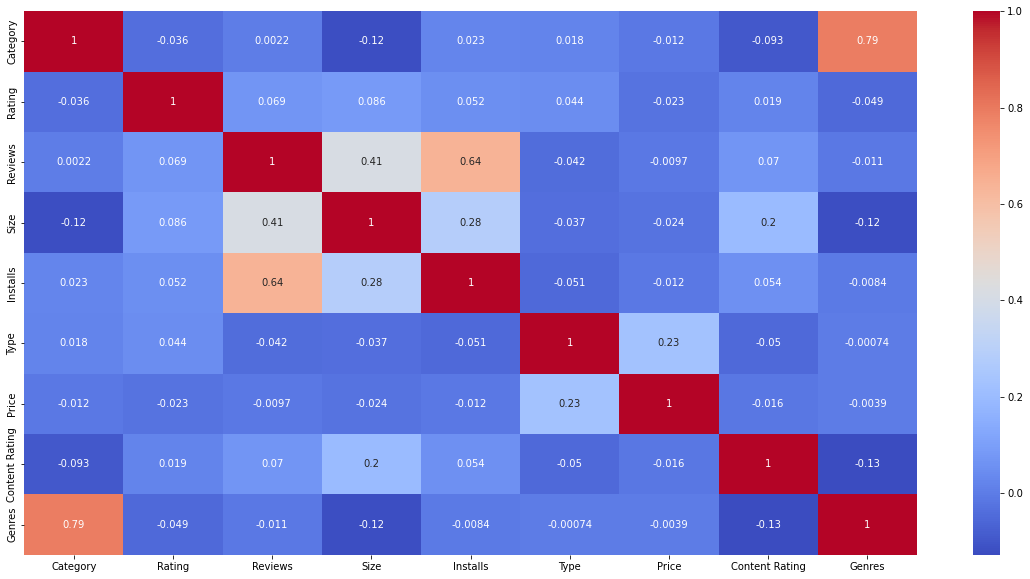

In [29]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.heatmap(train_data.corr(),annot = True, cmap = 'coolwarm')

In [30]:
# Model Training
# Standardize data
# Columns not to be standardized. These are columns with categorical data, 
# also we don't standardize our target vraiable
cols = ['Category', 'Type', 'Content Rating', 'Genres', 'Rating']

# Pick remaining columns and standardize them 
columns = [c for c in train_data.columns if c not in cols]
scaler = StandardScaler()
scaler.fit(train_data[columns])
train_data[columns] = scaler.transform(train_data[columns])

# Check data after standarization
train_data.head()

,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres
0,0,4.1,-0.151664,-0.140860,-0.181770,0,-0.064419,1,9
1,0,3.9,-0.151388,-0.366005,-0.176007,0,-0.064419,1,12
2,0,4.7,-0.121828,-0.604659,-0.123084,0,-0.064419,1,9
3,0,4.5,-0.078063,0.129314,0.406145,0,-0.064419,4,9
4,0,4.3,-0.151388,-0.870330,-0.180712,0,-0.064419,1,11


array([[<AxesSubplot:xlabel='Category', ylabel='Category'>,
        <AxesSubplot:xlabel='Rating', ylabel='Category'>,
        <AxesSubplot:xlabel='Reviews', ylabel='Category'>,
        <AxesSubplot:xlabel='Size', ylabel='Category'>,
        <AxesSubplot:xlabel='Installs', ylabel='Category'>,
        <AxesSubplot:xlabel='Type', ylabel='Category'>,
        <AxesSubplot:xlabel='Price', ylabel='Category'>,
        <AxesSubplot:xlabel='Content Rating', ylabel='Category'>,
        <AxesSubplot:xlabel='Genres', ylabel='Category'>],
       [<AxesSubplot:xlabel='Category', ylabel='Rating'>,
        <AxesSubplot:xlabel='Rating', ylabel='Rating'>,
        <AxesSubplot:xlabel='Reviews', ylabel='Rating'>,
        <AxesSubplot:xlabel='Size', ylabel='Rating'>,
        <AxesSubplot:xlabel='Installs', ylabel='Rating'>,
        <AxesSubplot:xlabel='Type', ylabel='Rating'>,
        <AxesSubplot:xlabel='Price', ylabel='Rating'>,
        <AxesSubplot:xlabel='Content Rating', ylabel='Rating'>,
        <Axes

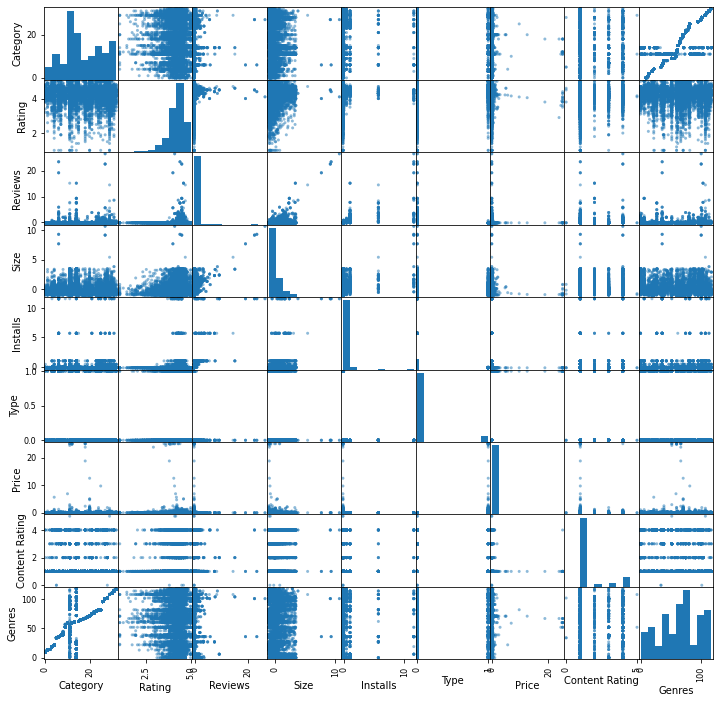

In [31]:
pd.plotting.scatter_matrix(train_data, figsize=(12,12))

# Rating vs Reviews

In [77]:
x=train_data.Reviews.to_numpy()
y=train_data.Rating.to_numpy()

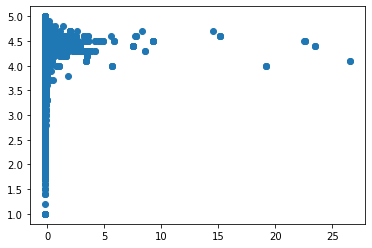

In [78]:
plt.scatter(x,y)

In [79]:
x=x/30.0
y=y/5.0

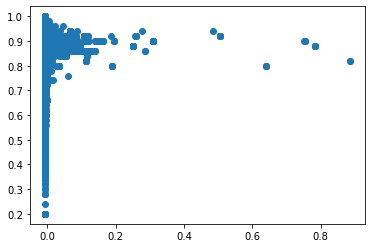

In [80]:
plt.scatter(x,y)

In [81]:
m,c=np.random.random(),np.random.random()

In [82]:
def learn(x,y,m,c,epoch):
    for i in range(epoch):
        error=y-(m*x+c)
        x_error=(y-(m*x+c))*x
        error=np.sum(error)/len(x)
        x_error=np.sum(x_error)/len(x)
        learning_rate = 0.01
        delta_m= learning_rate *x_error
        delta_c =learning_rate*error
        m+=delta_m
        c+=delta_c
    return(m,c)   

In [83]:
m,c=learn(x,y,m,c,20000)

In [84]:
x1=[0,1]
y1=[0*m+c,1*m+c]

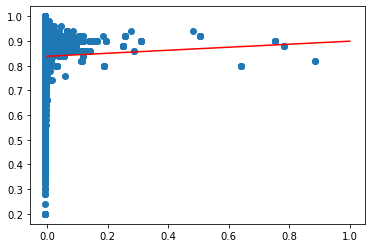

In [85]:
plt.scatter(x,y)
plt.plot(x1,y1, color='red')

# Rating vs Installs

In [86]:
x=train_data.Installs.to_numpy()
y=train_data.Rating.to_numpy()

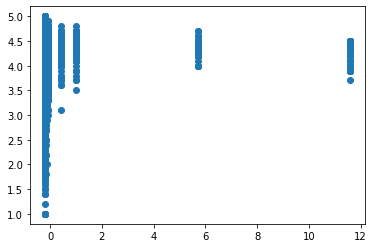

In [87]:
plt.scatter(x,y)

In [88]:
x=x/15.0
y=y/5.0

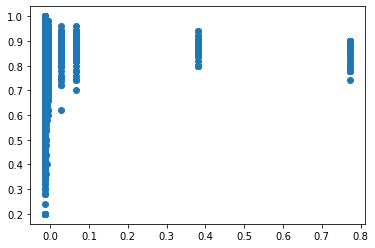

In [89]:
plt.scatter(x,y)

In [90]:
m,c=np.random.random(),np.random.random()

In [91]:
def learn(x,y,m,c,epoch):
    for i in range(epoch):
        error=y-(m*x+c)
        x_error=(y-(m*x+c))*x
        error=np.sum(error)/len(x)
        x_error=np.sum(x_error)/len(x)
        learning_rate = 0.01
        delta_m= learning_rate *x_error
        delta_c =learning_rate*error
        m+=delta_m
        c+=delta_c
    return(m,c)   

In [92]:
m,c=learn(x,y,m,c,20000)

In [93]:
x1=[0,1]
y1=[0*m+c,1*m+c]

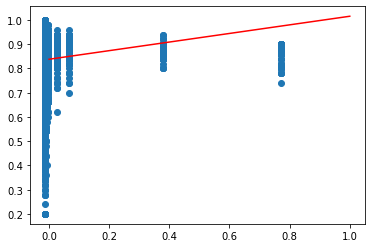

In [94]:
plt.scatter(x,y)
plt.plot(x1,y1, color='red')

# Rating vs App size

In [95]:
x=train_data.Size.to_numpy()
y=train_data.Rating.to_numpy()

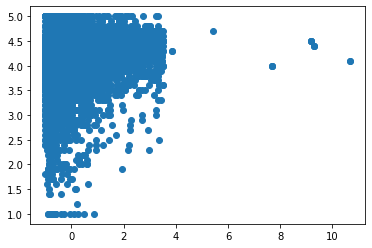

In [96]:
plt.scatter(x,y)

In [97]:
x=x/15.0
y=y/6.0

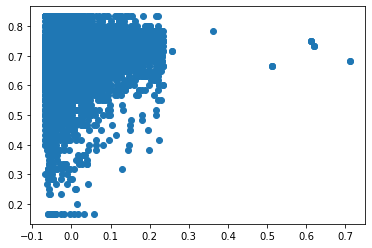

In [98]:
plt.scatter(x,y)

In [99]:
m,c=np.random.random(),np.random.random()

In [100]:
def learn(x,y,m,c,epoch):
    for i in range(epoch):
        error=y-(m*x+c)
        x_error=(y-(m*x+c))*x
        error=np.sum(error)/len(x)
        x_error=np.sum(x_error)/len(x)
        learning_rate = 0.01
        delta_m= learning_rate *x_error
        delta_c =learning_rate*error
        m+=delta_m
        c+=delta_c
    return(m,c)   

In [101]:
m,c=learn(x,y,m,c,20000)

In [102]:
x1=[0,1]
y1=[0*m+c,1*m+c]

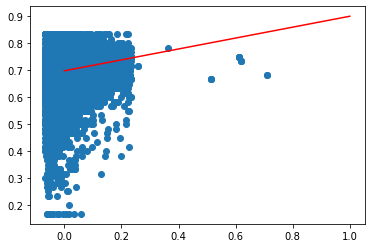

In [103]:
plt.scatter(x,y)
plt.plot(x1,y1,color='red')

# Rating vs Category

In [104]:
x=train_data.Category.to_numpy()
y=train_data.Rating.to_numpy()

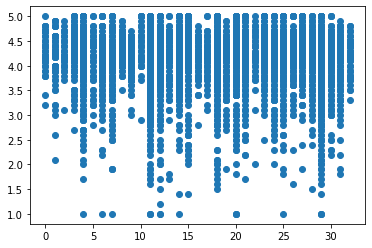

In [105]:
plt.scatter(x,y)

In [106]:
x=x/40.0
y=y/6.0

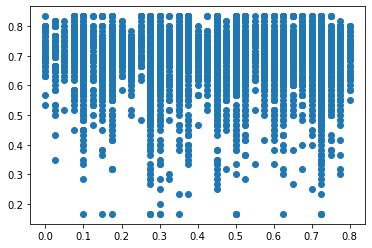

In [107]:
plt.scatter(x,y)

In [108]:
m,c=np.random.random(),np.random.random()

In [109]:
def learn(x,y,m,c,epoch):
    for i in range(epoch):
        error=y-(m*x+c)
        x_error=(y-(m*x+c))*x
        error=np.sum(error)/len(x)
        x_error=np.sum(x_error)/len(x)
        learning_rate = 0.01
        delta_m= learning_rate *x_error
        delta_c =learning_rate*error
        m+=delta_m
        c+=delta_c
    return(m,c)   

In [110]:
m,c=learn(x,y,m,c,20000)

In [111]:
x1=[0,1]
y1=[0*m+c,1*m+c]

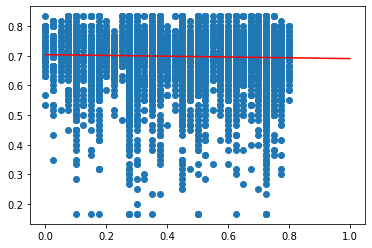

In [112]:
plt.scatter(x,y)
plt.plot(x1,y1,color='red')

# Multiple Linear Regression

In [68]:
from sklearn import linear_model

In [69]:
df1=pd.DataFrame(train_data,columns=['Rating','Size','Category','Reviews'])

In [70]:
x=df1.drop(['Rating'],axis=1).values
y=df1['Rating'].values

In [71]:
print(x)

[[-1.40859806e-01  0.00000000e+00 -1.51663816e-01]
 [-3.66005050e-01  0.00000000e+00 -1.51387837e-01]
 [-6.04659009e-01  0.00000000e+00 -1.21828353e-01]
 ...
 [-5.68635770e-01  2.00000000e+01 -1.51717099e-01]
 [ 3.54979661e-01  3.00000000e+00 -1.51679186e-01]
 [-1.40859806e-01  1.80000000e+01 -1.56730444e-02]]


In [72]:
print(y)

[4.1        3.9        4.7        ... 4.15869989 4.5        4.5       ]


In [73]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=0)

In [74]:
from sklearn.linear_model import LinearRegression
ml=LinearRegression()
ml.fit(x_train,y_train)

LinearRegression()

In [75]:
y_pred=ml.predict(x_test)

Text(0.5, 1.0, 'Actual vs Predicted')

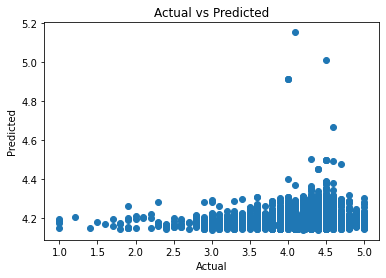

In [76]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')

In [77]:
pred_y_df=pd.DataFrame({'Actual Value':y_test,'Predicted value':y_pred,'Difference': y_test-y_pred})
pred_y_df[0:20]

,Actual Value,Predicted value,Difference
0,4.300000,4.315727,-0.015727
1,3.600000,4.185045,-0.585045
2,4.500000,4.179191,0.320809
3,4.400000,4.208801,0.191199
4,4.400000,4.159018,0.240982
5,4.500000,4.250957,0.249043
6,4.400000,4.201490,0.198510
7,4.238189,4.242144,-0.003955
8,4.600000,4.222527,0.377473
9,3.800000,4.212885,-0.412885


# Linear Regression

In [78]:
# Train Test Split
# Split data to 70% of the training and 30% for the validation
y = train_data['Rating']
X = train_data.drop(columns=['Rating'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
print("Training Set Dimensions:", X_train.shape)
print("Validation Set Dimensions:", X_test.shape)

Training Set Dimensions: (7587, 8)
Validation Set Dimensions: (3252, 8)


In [79]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [80]:
y_pred=model.predict(X_test)

In [81]:
y_pred[1:11]

array([4.19957466, 4.19778009, 4.18667576, 4.17939161, 4.13456031,
       4.329273  , 4.24349236, 4.33803713, 4.18066555, 4.13309046])

In [82]:
# Measure mean squared error for validation sets
print('Mean squared Error for Test Set:', mean_squared_error(y_test, y_pred))

Mean squared Error for Test Set: 0.22553823371681142


In [83]:
from sklearn.metrics import mean_absolute_error

In [84]:
# Measure mean absolute error for validation sets
print('Mean absolute Error for Test Set:', mean_absolute_error(y_test, y_pred))

Mean absolute Error for Test Set: 0.31099483057920124


In [85]:
from sklearn.metrics import r2_score

In [86]:
# Measure R-squared for validation sets
print('R-squared Error for Test Set:', r2_score(y_test, y_pred))

R-squared Error for Test Set: 0.014658464835751284


In [87]:
import math
# Measure root mean squared error for validation sets
print('Root mean squared Error for Test Set:', math.sqrt(mean_squared_error(y_test, y_pred)))

Root mean squared Error for Test Set: 0.47490865828789797


### KNN Model: K-Nearest Neighbors Model

In [88]:
from sklearn.neighbors import KNeighborsRegressor

In [89]:
# Fit model
knr = KNeighborsRegressor(n_neighbors = 5)
knr.fit(X_train, y_train)

# Measure mean squared error for training and validation sets
print('Mean squared Error for Training Set:', mean_squared_error(y_train, knr.predict(X_train)))
print('Mean squared Error for Test Set:', mean_squared_error(y_test, knr.predict(X_test)))

Mean squared Error for Training Set: 0.1618615339949217
Mean squared Error for Test Set: 0.24331168271222978


# Random Forest Regressor

In [90]:
from sklearn.ensemble import RandomForestRegressor

In [91]:
# Train Random Forest Regressor
randomf = RandomForestRegressor(n_estimators=300)
randomf.fit(X_train, y_train)

# Measure mean squared error for training and validation sets
print('Mean squared Error for Training Set:', mean_squared_error(y_train, randomf.predict(X_train)))
print('Mean squared Error for Test Set:', mean_squared_error(y_test, randomf.predict(X_test)))

Mean squared Error for Training Set: 0.028226766895962947
Mean squared Error for Test Set: 0.19902366809134187


feature: Category = 0.09787285756361797
feature: Reviews = 0.3393285584647029
feature: Size = 0.29473025819616694
feature: Installs = 0.10101916829515543
feature: Type = 0.005276351932548129
feature: Price = 0.02655492907226782
feature: Content Rating = 0.025566720490326933
feature: Genres = 0.10965115598521398


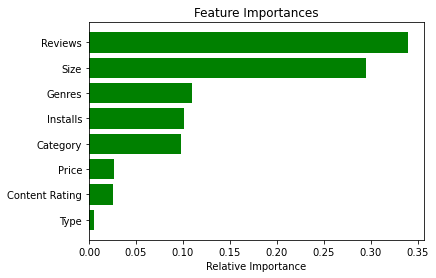

In [92]:
# Important features for random forest regressor
for name, importance in zip(X.columns, randomf.feature_importances_):
    print('feature:', name, "=", importance)
    
importances = randomf.feature_importances_
indices = np.argsort(importances)
features = X.columns
plt.figure(figsize=(6, 4))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

# Bagging Regressor

In [93]:
from sklearn.ensemble import BaggingRegressor 

In [94]:
# Fit model
br = BaggingRegressor(random_state=300)
                            
br.fit(X_train, y_train)

# Measure mean squared error for training and validation sets
print('Mean squared Error for Training Set:', mean_squared_error(y_train, br.predict(X_train)))
print('Mean squared Error for Test Set:', mean_squared_error(y_test, br.predict(X_test)))

Mean squared Error for Training Set: 0.03989299884581395
Mean squared Error for Test Set: 0.21711816904674575


### Conclusion

Above all techniques, Random Forest Regressor performed best with testing mean squared error of 0.19 which is also confirmed with the help of Lazy-Library which tells us which model is best among all types.
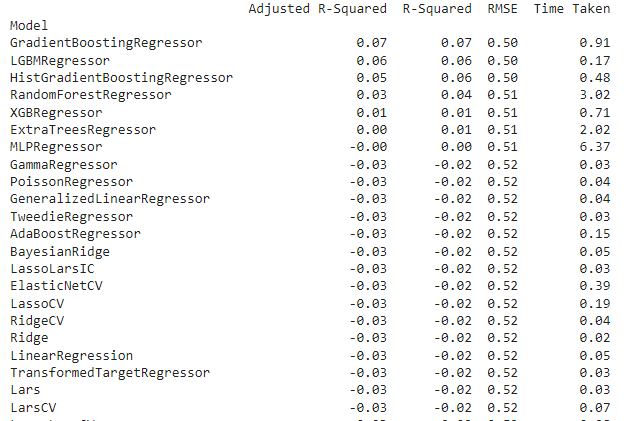

# P1 (Reviews)

In [95]:
X = train_data.iloc[:, 2:3].values
Y = train_data.iloc[:, 1].values

In [96]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [97]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [98]:
regressor.predict(x_test)

array([4.28854279, 4.18571249, 4.18571477, ..., 4.19944098, 4.18698091,
       4.1879264 ])

In [99]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("Coeff: %0.3f" % regressor.coef_)
print("Intercept: %0.3f" % regressor.intercept_)
print("R2 score : %.3f" % r2_score(y_test, regressor.predict(x_test)))
print("MSE: %.3f" % mean_squared_error(y_test, regressor.predict(x_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, regressor.predict(x_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, regressor.predict(x_test))))

Coeff: 0.037
Intercept: 4.191
R2 score : 0.003
MSE: 0.229
RMSE: 0.479
MAE: 0.560


In [100]:
#AIC,BIC,RSS
y = train_data['Rating']

#define predictor variables
x = train_data[['Reviews']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)
print(model.bic)
print(model.ssr)

14764.413645446773
14778.995457486404
2477.032016599371


In [101]:
model = LinearRegression()
X, y = train_data[["Reviews"]], train_data.Rating
model.fit(X, y)

#display adjusted R-squared
1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

0.004611067021882742

In [102]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*2477.032016599371
Cp=(1/m)*(2477.032016599371+2* hat_sigma_squared)
Cp

0.22857174647959502

# P2 (Installs)

In [103]:
X = train_data.iloc[:, 4:5].values
Y = train_data.iloc[:, 1].values

In [104]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [105]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [106]:
regressor.predict(x_test)

array([4.34001661, 4.18644466, 4.18644466, ..., 4.20180158, 4.18798007,
       4.1895158 ])

In [107]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("Coeff: %0.3f" % regressor.coef_)
print("Intercept: %0.3f" % regressor.intercept_)
print("R2 score : %.3f" % r2_score(y_test, regressor.predict(x_test)))
print("MSE: %.3f" % mean_squared_error(y_test, regressor.predict(x_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, regressor.predict(x_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, regressor.predict(x_test))))

Coeff: 0.026
Intercept: 4.191
R2 score : 0.002
MSE: 0.229
RMSE: 0.479
MAE: 0.561


In [108]:
#AIC,BIC,RSS
y = train_data['Rating']

#define predictor variables
x = train_data[['Installs']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)
print(model.bic)
print(model.ssr)

14786.263645226072
14800.845457265703
2482.0304240419223


In [109]:
model = LinearRegression()
X, y = train_data[["Reviews"]], train_data.Rating
model.fit(X, y)

#display adjusted R-squared
1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

0.004611067021882742

In [110]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*2482.0304240419223
Cp=(1/m)*(2482.0304240419223+2* hat_sigma_squared)
Cp

0.22903298182540577

# P1+P2 (Reviews and Installs)

In [111]:
X = train_data.iloc[:, 2:5:2].values
Y = train_data.iloc[:, 1].values

In [112]:
X.shape

(10839, 2)

In [113]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [114]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [115]:
regressor.predict(x_test)

array([4.31357579, 4.18517002, 4.18517207, ..., 4.20110345, 4.18666955,
       4.18787927])

In [116]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print( regressor.coef_)
print("Intercept: %0.3f" % regressor.intercept_)
print("R2 score : %.3f" % r2_score(y_test, regressor.predict(x_test)))
print("MSE: %.3f" % mean_squared_error(y_test, regressor.predict(x_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, regressor.predict(x_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, regressor.predict(x_test))))

[0.03329882 0.00613863]
Intercept: 4.191
R2 score : 0.003
MSE: 0.229
RMSE: 0.479
MAE: 0.560


In [117]:
#AIC,BIC,RSS
y = train_data['Rating']

#define predictor variables
x = train_data[['Installs','Reviews']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)
print(model.bic)
print(model.ssr)

14765.282325153008
14787.155043212455
2476.7734899504253


In [118]:
model = LinearRegression()
X, y = train_data[["Reviews"]], train_data.Rating
model.fit(X, y)

#display adjusted R-squared
1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

0.004611067021882742

In [119]:
#cp

m=len(Y)
p=2
hat_sigma_squared=(1/(m-p-1))*2476.7734899504253
Cp=(1/m)*(2476.7734899504253+2* 2*hat_sigma_squared)
Cp

0.22859006973694934

# All Predictors

In [120]:
X = train_data.iloc[:, 2:].values
Y = train_data.iloc[:, 1].values

In [121]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

In [122]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(x_train, y_train)

LinearRegression()

In [123]:
regressor.predict(x_test)

array([4.36149235, 4.18529968, 4.28638138, ..., 4.22225606, 4.16706078,
       4.31906926])

In [124]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print( regressor.coef_)
print("Intercept: %0.3f" % regressor.intercept_)
print("R2 score : %.3f" % r2_score(y_test, regressor.predict(x_test)))
print("MSE: %.3f" % mean_squared_error(y_test, regressor.predict(x_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, regressor.predict(x_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, regressor.predict(x_test))))

[ 0.02123165  0.03174628  0.00602473  0.10860319 -0.01709335  0.00127802
 -0.00047579]
Intercept: 4.212
R2 score : 0.012
MSE: 0.227
RMSE: 0.477
MAE: 0.555


In [125]:
#AIC,BIC,RSS
y = train_data['Rating']

#define predictor variables
x = train_data[['Installs','Reviews','Size','Type','Price','Content Rating','Genres']]

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)
print(model.bic)
print(model.ssr)

14676.303637211453
14734.63088536998
2454.2592469880774


In [126]:
model = LinearRegression()
X, y = train_data[["Reviews"]], train_data.Rating
model.fit(X, y)

#display adjusted R-squared
1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

0.004611067021882742

In [127]:
#cp

m=len(Y)
p=7
hat_sigma_squared=(1/(m-p-1))*2476.7734899504253
Cp=(1/m)*(2476.7734899504253+2* 7*hat_sigma_squared)
Cp

0.2288010824730285

# Pzero

In [128]:
y = train_data['Rating']
y_zero = np.full((len(train_data.Rating),1),train_data.Rating.mean())
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(y_zero, y)

LinearRegression()

In [129]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print( regressor.coef_)
print("Intercept: %0.3f" % regressor.intercept_)
print("R2 score : %.3f" % r2_score(y, y_zero))
print("MSE: %.3f" % mean_squared_error(y, y_zero))
print("RMSE: %.3f" % sqrt(mean_squared_error(y, y_zero)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y, y_zero)))

[-0.09335032]
Intercept: 4.581
R2 score : 0.000
MSE: 0.230
RMSE: 0.479
MAE: 0.563


In [130]:
#AIC,BIC,RSS
y = train_data['Rating']

#define predictor variables
x = y_zero

#add constant to predictor variables
x = sm.add_constant(x)

#fit regression model
model = sm.OLS(y, x).fit()

#view AIC of model
print(model.aic)
print(model.bic)
print(model.ssr)

14813.508723833693
14820.799629853509
2488.73631830937


In [131]:
model = LinearRegression()
X, y = y_zero, train_data.Rating
model.fit(X, y)

#display adjusted R-squared
1 - (1-model.score(X, y))*(len(y)-1)/(len(y)-X.shape[1]-1)

-9.227646027487602e-05

In [132]:
#cp

m=len(y)
p=0
hat_sigma_squared=(1/(m-p-1))*2488.73631830937
Cp=(1/m)*(2488.73631830937+2*0* hat_sigma_squared)
Cp

0.22960940292548848

# Ridge Regression

### For  P1 (Reviews)

In [133]:
X = train_data[['Reviews']]
Y = train_data['Rating']

In [134]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [135]:
from sklearn.linear_model import Ridge
ridgeReg=Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)
pred=ridgeReg.predict(X_test)
mse=np.mean((pred-y_test)**2)
mse

0.22572668501506277

In [136]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(ridgeReg.coef_)
print("Intercept: %0.3f" % ridgeReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,ridgeReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, ridgeReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, ridgeReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, ridgeReg.predict(X_test))))

[0.03102091]
Intercept: 4.191
R2 score : 0.005
MSE: 0.226
RMSE: 0.475
MAE: 0.558


In [137]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const      4.190773
Reviews    0.032572
dtype: float64

In [138]:
print(lr.ssr)

1742.9957318861946


In [139]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1742.9957318861946
Cp=(1/m)*(1742.9957318861946+2*1* hat_sigma_squared)
Cp

0.16083747641286283

In [140]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     35.97
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           2.10e-09
Time:                        05:42:26   Log-Likelihood:                -5185.9
No. Observations:                7587   AIC:                         1.038e+04
Df Residuals:                    7585   BIC:                         1.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1908      0.006    761.478      0.000       4.180       4.202
Reviews        0.0326      0.005      5.997      0.000       0.022       0.043
==============================================================================
Omnibus:                     3172.793   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18735.978
Skew:                          -1.920   Prob(JB):                         0.00
Kurtosis:                       9.673   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For  P2 (Installs)

In [141]:
X = train_data[['Installs']]
Y = train_data['Rating']

In [142]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [143]:
from sklearn.linear_model import Ridge
ridgeReg=Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)
pred=ridgeReg.predict(X_test)
mse=np.mean((pred-y_test)**2)
mse

0.2261539292724255

In [144]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(ridgeReg.coef_)
print("Intercept: %0.3f" % ridgeReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,ridgeReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, ridgeReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, ridgeReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, ridgeReg.predict(X_test))))

[0.0227551]
Intercept: 4.191
R2 score : 0.003
MSE: 0.226
RMSE: 0.476
MAE: 0.559


In [145]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const       4.190641
Installs    0.023893
dtype: float64

In [146]:
print(lr.ssr)

1746.6225916651158


In [147]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1746.6225916651158
Cp=(1/m)*(1746.6225916651158+2*1* hat_sigma_squared)
Cp

0.1611721501951754

In [148]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     20.15
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           7.28e-06
Time:                        05:42:36   Log-Likelihood:                -5193.8
No. Observations:                7587   AIC:                         1.039e+04
Df Residuals:                    7585   BIC:                         1.041e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1906      0.006    760.635      0.000       4.180       4.201
Installs       0.0239      0.005      4.488      0.000       0.013       0.034
==============================================================================
Omnibus:                     3160.891   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18566.871
Skew:                          -1.913   Prob(JB):                         0.00
Kurtosis:                       9.640   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For P3 (Size)

In [149]:
X = train_data[['Size']]
Y = train_data['Rating']

In [150]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [151]:
from sklearn.linear_model import Ridge
ridgeReg=Ridge(alpha=0.05, normalize=True)
ridgeReg.fit(X_train,y_train)
pred=ridgeReg.predict(X_test)
mse=np.mean((pred-y_test)**2)
mse

0.22482748112083453

In [152]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(ridgeReg.coef_)
print("Intercept: %0.3f" % ridgeReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,ridgeReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, ridgeReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, ridgeReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, ridgeReg.predict(X_test))))

[0.03738379]
Intercept: 4.191
R2 score : 0.009
MSE: 0.225
RMSE: 0.474
MAE: 0.557


In [153]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.190776
Size     0.039253
dtype: float64

In [154]:
print(lr.ssr)

1739.5159280750015


In [155]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1739.5159280750015
Cp=(1/m)*(1739.5159280750015+2*1* hat_sigma_squared)
Cp

0.16051637243471453

In [156]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     51.22
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           9.05e-13
Time:                        05:42:45   Log-Likelihood:                -5178.3
No. Observations:                7587   AIC:                         1.036e+04
Df Residuals:                    7585   BIC:                         1.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1908      0.005    762.241      0.000       4.180       4.202
Size           0.0393      0.005      7.156      0.000       0.029       0.050
==============================================================================
Omnibus:                     3138.109   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18420.422
Skew:                          -1.897   Prob(JB):                         0.00
Kurtosis:                       9.624   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Lasso Regression

### For P1 (Reviews)

In [157]:
X = train_data[['Reviews']]
Y = train_data['Rating']

In [158]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [159]:
from sklearn.linear_model import Lasso
lassoReg=Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train,y_train)
laspred=lassoReg.predict(X_test)
las_mse=np.mean((laspred-y_test)**2)
las_mse

0.22677906326072836

In [160]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("Coeffiecient: %0.3f" % lassoReg.coef_)
print("Intercept: %0.3f" % lassoReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,lassoReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, lassoReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, lassoReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, lassoReg.predict(X_test))))

Coeffiecient: 0.000
Intercept: 4.191
R2 score : -0.000
MSE: 0.227
RMSE: 0.476
MAE: 0.560


In [161]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const      4.190773
Reviews    0.032572
dtype: float64

In [162]:
print(lr.ssr)

1742.9957318861946


In [163]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1742.9957318861946
Cp=(1/m)*(1742.9957318861946+2*1* hat_sigma_squared)
Cp

0.16083747641286283

In [164]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     35.97
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           2.10e-09
Time:                        05:42:57   Log-Likelihood:                -5185.9
No. Observations:                7587   AIC:                         1.038e+04
Df Residuals:                    7585   BIC:                         1.039e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1908      0.006    761.478      0.000       4.180       4.202
Reviews        0.0326      0.005      5.997      0.000       0.022       0.043
==============================================================================
Omnibus:                     3172.793   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18735.978
Skew:                          -1.920   Prob(JB):                         0.00
Kurtosis:                       9.673   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For P2 (Installs)

In [165]:
X = train_data[['Installs']]
Y = train_data['Rating']

In [166]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [167]:
from sklearn.linear_model import Lasso
lassoReg=Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train,y_train)
laspred=lassoReg.predict(X_test)
las_mse=np.mean((laspred-y_test)**2)
las_mse

0.22677906326072836

In [168]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("Coeffiecient: %0.3f" % lassoReg.coef_)
print("Intercept: %0.3f" % lassoReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,lassoReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, lassoReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, lassoReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, lassoReg.predict(X_test))))

Coeffiecient: 0.000
Intercept: 4.191
R2 score : -0.000
MSE: 0.227
RMSE: 0.476
MAE: 0.560


In [169]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const       4.190641
Installs    0.023893
dtype: float64

In [170]:
print(lr.ssr)

1746.6225916651158


In [171]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1746.6225916651158
Cp=(1/m)*(1746.6225916651158+2*1* hat_sigma_squared)
Cp

0.1611721501951754

In [172]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     20.15
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           7.28e-06
Time:                        05:43:06   Log-Likelihood:                -5193.8
No. Observations:                7587   AIC:                         1.039e+04
Df Residuals:                    7585   BIC:                         1.041e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1906      0.006    760.635      0.000       4.180       4.201
Installs       0.0239      0.005      4.488      0.000       0.013       0.034
==============================================================================
Omnibus:                     3160.891   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18566.871
Skew:                          -1.913   Prob(JB):                         0.00
Kurtosis:                       9.640   Cond. No.                         1.04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For P3 (Size)

In [173]:
X = train_data[['Size']]
Y = train_data['Rating']

In [174]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=1)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

(7587, 1) (3252, 1) (7587,) (3252,)


In [175]:
from sklearn.linear_model import Lasso
lassoReg=Lasso(alpha=0.05, normalize=True)
lassoReg.fit(X_train,y_train)
laspred=lassoReg.predict(X_test)
las_mse=np.mean((laspred-y_test)**2)
las_mse

0.22677906326072836

In [176]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("Coeffiecient: %0.3f" % lassoReg.coef_)
print("Intercept: %0.3f" % lassoReg.intercept_)
print("R2 score : %.3f" % r2_score(y_test,lassoReg.predict(X_test)))
print("MSE: %.3f" % mean_squared_error(y_test, lassoReg.predict(X_test)))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, lassoReg.predict(X_test))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, lassoReg.predict(X_test))))

Coeffiecient: 0.000
Intercept: 4.191
R2 score : -0.000
MSE: 0.227
RMSE: 0.476
MAE: 0.560


In [177]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_train)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.190776
Size     0.039253
dtype: float64

In [178]:
print(lr.ssr)

1739.5159280750015


In [179]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1739.5159280750015
Cp=(1/m)*(1739.5159280750015+2*1* hat_sigma_squared)
Cp

0.16051637243471453

In [180]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     51.22
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           9.05e-13
Time:                        05:43:14   Log-Likelihood:                -5178.3
No. Observations:                7587   AIC:                         1.036e+04
Df Residuals:                    7585   BIC:                         1.037e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.1908      0.005    762.241      0.000       4.180       4.202
Size           0.0393      0.005      7.156      0.000       0.029       0.050
==============================================================================
Omnibus:                     3138.109   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            18420.422
Skew:                          -1.897   Prob(JB):                         0.00
Kurtosis:                       9.624   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Polynomial Regression

### For P1 (Reviews)

In [181]:
X = train_data[['Reviews']]
Y = train_data['Rating']

In [182]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

In [183]:
from sklearn.preprocessing import PolynomialFeatures
polynom=PolynomialFeatures(degree=5)
X_polynom=polynom.fit_transform(X_train)
X_polynom

array([[ 1.00000000e+00, -1.50144564e-01,  2.25433902e-02,
        -3.38476749e-03,  5.08204440e-04, -7.63041342e-05],
       [ 1.00000000e+00, -1.51713342e-01,  2.30169381e-02,
        -3.49197659e-03,  5.29779437e-04, -8.03746088e-05],
       [ 1.00000000e+00, -1.49790368e-01,  2.24371544e-02,
        -3.36086962e-03,  5.03425898e-04, -7.54083507e-05],
       ...,
       [ 1.00000000e+00, -1.27507443e-01,  1.62581481e-02,
        -2.07303490e-03,  2.64327381e-04, -3.37037086e-05],
       [ 1.00000000e+00, -1.51700362e-01,  2.30130000e-02,
        -3.49108044e-03,  5.29598168e-04, -8.03402341e-05],
       [ 1.00000000e+00,  3.16472634e-01,  1.00154928e-01,
         3.16962939e-02,  1.00310096e-02,  3.17454004e-03]])

In [184]:
PolyRegr=LinearRegression()
PolyRegr.fit(X_polynom,y_train)

LinearRegression()

In [185]:
y_predict_polyr=PolyRegr.predict(polynom.fit_transform(X_test))
from sklearn import metrics
r_square=metrics.r2_score(y_test,y_predict_polyr)
r_square

0.0179684205474705

In [186]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(PolyRegr.coef_)
print("Intercept: %0.3f" % PolyRegr.intercept_)
print("R2 score : %.3f" % r2_score(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("MSE: %.3f" % mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))

[ 0.00000000e+00  4.11792554e-01 -1.50466344e-01  1.76568916e-02
 -7.97928304e-04  1.22262004e-05]
Intercept: 4.231
R2 score : 0.018
MSE: 0.226
RMSE: 0.475
MAE: 0.557


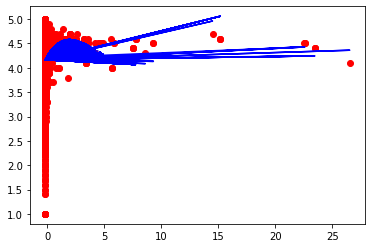

In [187]:
plt.scatter(X_train, y_train,color='red')
plt.plot(X_train, PolyRegr.predict(polynom.fit_transform(X_train)),color='blue')

In [188]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_polynom)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.231012
x1       0.411793
x2      -0.150466
x3       0.017657
x4      -0.000798
x5       0.000012
dtype: float64

In [189]:
print(lr.ssr)

1697.2194190803843


In [190]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1697.2194190803843
Cp=(1/m)*(1697.2194190803843+2*1* hat_sigma_squared)
Cp


0.15661340030270227

In [191]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     39.16
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           7.55e-40
Time:                        05:43:53   Log-Likelihood:                -5084.9
No. Observations:                7587   AIC:                         1.018e+04
Df Residuals:                    7581   BIC:                         1.022e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2310      0.007    641.613      0.000       4.218       4.244
x1             0.4118      0.033     12.555      0.000       0.347       0.476
x2            -0.1505      0.017     -8.994      0.000      -0.183      -0.118
x3             0.0177      0.002      7.470      0.000       0.013       0.022
x4            -0.0008      0.000     -6.491      0.000      -0.001      -0.001
x5          1.223e-05   2.13e-06      5.747      0.000    8.06e-06    1.64e-05
==============================================================================
Omnibus:                     3227.896   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21024.200
Skew:                          -1.921   Prob(JB):                         0.00
Kurtosis:                      10.193   Cond. No.                     1.60e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.6e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### For P2 (Installs)

In [192]:
X = train_data[['Installs']]
Y = train_data['Rating']

In [193]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

In [194]:
from sklearn.preprocessing import PolynomialFeatures
polynom=PolynomialFeatures(degree=5)
X_polynom=polynom.fit_transform(X_train)
X_polynom

array([[ 1.00000000e+00, -1.80711566e-01,  3.26566701e-02,
        -5.90143800e-03,  1.06645810e-03, -1.92721314e-04],
       [ 1.00000000e+00, -1.81875872e-01,  3.30788327e-02,
        -6.01624152e-03,  1.09420917e-03, -1.99010246e-04],
       [ 1.00000000e+00, -1.70126971e-01,  2.89431862e-02,
        -4.92401660e-03,  8.37708028e-04, -1.42516729e-04],
       ...,
       [ 1.00000000e+00, -1.70126971e-01,  2.89431862e-02,
        -4.92401660e-03,  8.37708028e-04, -1.42516729e-04],
       [ 1.00000000e+00, -1.81875872e-01,  3.30788327e-02,
        -6.01624152e-03,  1.09420917e-03, -1.99010246e-04],
       [ 1.00000000e+00,  4.06145436e-01,  1.64954115e-01,
         6.69953612e-02,  2.72098602e-02,  1.10511605e-02]])

In [195]:
PolyRegr=LinearRegression()
PolyRegr.fit(X_polynom,y_train)

LinearRegression()

In [196]:
y_predict_polyr=PolyRegr.predict(polynom.fit_transform(X_test))
from sklearn import metrics
r_square=metrics.r2_score(y_test,y_predict_polyr)
r_square

0.025949995535503367

In [197]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(PolyRegr.coef_)
print("Intercept: %0.3f" % PolyRegr.intercept_)
print("R2 score : %.3f" % r2_score(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("MSE: %.3f" % mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))

[ 0.          0.70561162 -3.07995135  2.99488528 -0.62684387  0.03374295]
Intercept: 4.388
R2 score : 0.026
MSE: 0.224
RMSE: 0.473
MAE: 0.557


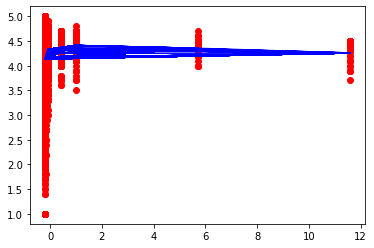

In [198]:
plt.scatter(X_train, y_train,color='red')
plt.plot(X_train, PolyRegr.predict(polynom.fit_transform(X_train)),color='blue')

In [199]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_polynom)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.387873
x1       0.705612
x2      -3.079951
x3       2.994885
x4      -0.626844
x5       0.033743
dtype: float64

In [200]:
print(lr.ssr)

1689.8477131108657


In [201]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1689.8477131108657
Cp=(1/m)*(1689.8477131108657+2*1* hat_sigma_squared)
Cp

0.1559331653696471

In [202]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     45.94
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           6.49e-47
Time:                        05:44:05   Log-Likelihood:                -5068.4
No. Observations:                7587   AIC:                         1.015e+04
Df Residuals:                    7581   BIC:                         1.019e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3879      0.018    238.212      0.000       4.352       4.424
x1             0.7056      0.067     10.543      0.000       0.574       0.837
x2            -3.0800      0.369     -8.354      0.000      -3.803      -2.357
x3             2.9949      0.441      6.788      0.000       2.130       3.860
x4            -0.6268      0.097     -6.492      0.000      -0.816      -0.438
x5             0.0337      0.005      6.392      0.000       0.023       0.044
==============================================================================
Omnibus:                     3098.363   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            19467.485
Skew:                          -1.842   Prob(JB):                         0.00
Kurtosis:                       9.929   Cond. No.                     1.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### For P3 (Size)

In [203]:
X = train_data[['Size']]
Y = train_data['Rating']

In [204]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

In [205]:
from sklearn.preprocessing import PolynomialFeatures
polynom=PolynomialFeatures(degree=3)
X_polynom=polynom.fit_transform(X_train)
X_polynom

array([[ 1.        , -0.14085981,  0.01984149, -0.00279487],
       [ 1.        ,  0.26440163,  0.06990822,  0.01848385],
       [ 1.        , -0.36600505,  0.1339597 , -0.04902993],
       ...,
       [ 1.        ,  0.39948878,  0.15959129,  0.06375493],
       [ 1.        , -0.14085981,  0.01984149, -0.00279487],
       [ 1.        ,  0.40537136,  0.16432594,  0.06661303]])

In [206]:
PolyRegr=LinearRegression()
PolyRegr.fit(X_polynom,y_train)

LinearRegression()

In [207]:
y_predict_polyr=PolyRegr.predict(polynom.fit_transform(X_test))
from sklearn import metrics
r_square=metrics.r2_score(y_test,y_predict_polyr)
r_square

0.0073576070086428524

In [208]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(PolyRegr.coef_)
print("Intercept: %0.3f" % PolyRegr.intercept_)
print("R2 score : %.3f" % r2_score(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("MSE: %.3f" % mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))

[ 0.          0.05850124 -0.01166628  0.00081405]
Intercept: 4.201
R2 score : 0.007
MSE: 0.228
RMSE: 0.478
MAE: 0.559


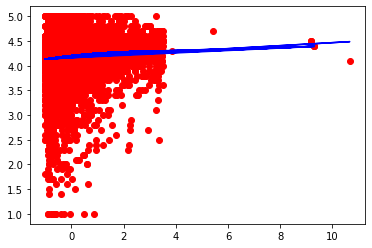

In [209]:
plt.scatter(X_train, y_train,color='red')
plt.plot(X_train, PolyRegr.predict(polynom.fit_transform(X_train)),color='blue')

In [210]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_polynom)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.201307
x1       0.058501
x2      -0.011666
x3       0.000814
dtype: float64

In [211]:
print(lr.ssr)

1726.128598259959


In [212]:
#cp

m=len(Y)
p=1
hat_sigma_squared=(1/(m-p-1))*1726.128598259959
Cp=(1/m)*(1726.128598259959+2*1* hat_sigma_squared)
Cp

0.15928103702684868

In [213]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     21.85
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           4.37e-14
Time:                        05:44:15   Log-Likelihood:                -5149.0
No. Observations:                7587   AIC:                         1.031e+04
Df Residuals:                    7583   BIC:                         1.033e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2013      0.007    585.974      0.000       4.187       4.215
x1             0.0585      0.009      6.824      0.000       0.042       0.075
x2            -0.0117      0.006     -1.967      0.049      -0.023   -4.14e-05
x3             0.0008      0.001      1.315      0.189      -0.000       0.002
==============================================================================
Omnibus:                     3234.952   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20551.533
Skew:                          -1.936   Prob(JB):                         0.00
Kurtosis:                      10.072   Cond. No.                         53.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### For All Predictors

In [214]:
X = train_data[['Installs','Reviews','Size','Type','Price','Content Rating','Genres']]
Y = train_data['Rating']

In [215]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.3,random_state=0)

In [216]:
from sklearn.preprocessing import PolynomialFeatures
polynom=PolynomialFeatures(degree=1)
X_polynom=polynom.fit_transform(X_train)
X_polynom

array([[ 1.00000000e+00, -1.80711566e-01, -1.50144564e-01, ...,
        -6.44189445e-02,  1.00000000e+00,  9.70000000e+01],
       [ 1.00000000e+00, -1.81875872e-01, -1.51713342e-01, ...,
        -6.44189445e-02,  1.00000000e+00,  1.08000000e+02],
       [ 1.00000000e+00, -1.70126971e-01, -1.49790368e-01, ...,
        -6.44189445e-02,  1.00000000e+00,  1.02000000e+02],
       ...,
       [ 1.00000000e+00, -1.70126971e-01, -1.27507443e-01, ...,
        -6.44189445e-02,  1.00000000e+00,  8.60000000e+01],
       [ 1.00000000e+00, -1.81875872e-01, -1.51700362e-01, ...,
        -6.44189445e-02,  1.00000000e+00,  3.90000000e+01],
       [ 1.00000000e+00,  4.06145436e-01,  3.16472634e-01, ...,
        -6.44189445e-02,  4.00000000e+00,  9.60000000e+01]])

In [217]:
PolyRegr=LinearRegression()
PolyRegr.fit(X_polynom,y_train)

LinearRegression()

In [218]:
y_predict_polyr=PolyRegr.predict(polynom.fit_transform(X_test))
from sklearn import metrics
r_square=metrics.r2_score(y_test,y_predict_polyr)
r_square

0.012371314142605394

In [219]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print(PolyRegr.coef_)
print("Intercept: %0.3f" % PolyRegr.intercept_)
print("R2 score : %.3f" % r2_score(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("MSE: %.3f" % mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test))))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, PolyRegr.predict(polynom.fit_transform(X_test)))))

[ 0.          0.00602473  0.02123165  0.03174628  0.10860319 -0.01709335
  0.00127802 -0.00047579]
Intercept: 4.212
R2 score : 0.012
MSE: 0.227
RMSE: 0.477
MAE: 0.555


In [220]:
import statsmodels.api as sm
X_train_sm=sm.add_constant(X_polynom)
lr=sm.OLS(y_train,X_train_sm).fit()
lr.params

const    4.212149
x1       0.006025
x2       0.021232
x3       0.031746
x4       0.108603
x5      -0.017093
x6       0.001278
x7      -0.000476
dtype: float64

In [221]:
print(lr.ssr)

1716.309478077619


In [222]:
#cp

m=len(Y)
p=7
hat_sigma_squared=(1/(m-p-1))*1716.3094780776185
Cp=(1/m)*(1716.3094780776185+2*7* hat_sigma_squared)
Cp

0.15855041570666106

In [223]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     15.61
Date:                Sat, 05 Feb 2022   Prob (F-statistic):           1.87e-20
Time:                        05:44:24   Log-Likelihood:                -5127.4
No. Observations:                7587   AIC:                         1.027e+04
Df Residuals:                    7579   BIC:                         1.033e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2121      0.015    272.023      0.000       4.182       4.243
x1             0.0060      0.007      0.847      0.397      -0.008       0.020
x2             0.0212      0.008      2.795      0.005       0.006       0.036
x3             0.0317      0.006      5.119      0.000       0.020       0.044
x4             0.1086      0.022      5.038      0.000       0.066       0.151
x5            -0.0171      0.007     -2.352      0.019      -0.031      -0.003
x6             0.0013      0.006      0.230      0.818      -0.010       0.012
x7            -0.0005      0.000     -2.795      0.005      -0.001      -0.000
==============================================================================
Omnibus:                     3272.539   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21192.339
Skew:                          -1.956   Prob(JB):                         0.00
Kurtosis:                      10.193   Cond. No.                         288.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Gradient Descent

### For P1 (Reviews)

In [224]:
def predicted_y(weight,x,intercept):
    y_lst=[]
    for i in range(len(x)):
        y_lst.append(weight@x[i]+intercept)
    return np.array(y_lst)
    

# linear loss
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

#derivative of loss w.r.t weight
def dldw(x,y,y_predicted):
    s=0
    n=len(y)
    for i in range(n):
        s+=-x[i]*(y[i]-y_predicted[i])
    return (2/n)*s
    

# derivative of loss w.r.t bias
def dldb(y,y_predicted):
    n=len(y)
    s=0
    for i in range(len(y)):
        s+=-(y[i]-y_predicted[i])
    return (2/n) * s

# gradient function
def gradient_descent(x,y):
    weight_vector=np.random.randn(x.shape[1])
    intercept=0
    epoch = 1000
    n = len(x)
    linear_loss=[]
    learning_rate = 0.01
    for i in range(epoch):
        
        
        y_predicted = predicted_y(weight_vector,x,intercept)
        
        weight_vector = weight_vector - learning_rate *dldw(x,y,y_predicted) 
        
        
        intercept = intercept - learning_rate * dldb(y,y_predicted)
        linear_loss.append(loss(y,y_predicted))
        
    plt.plot(np.arange(1,epoch),linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")
    
    return weight_vector,intercept

In [225]:
x_sr = train_data.iloc[:, 2:3].values
y = train_data.iloc[:, 1].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sr, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_transform=sc.fit_transform(x_train)

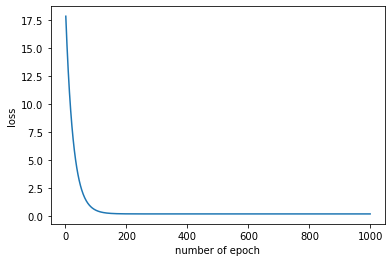

In [226]:
w,b=gradient_descent(X_transform,y_train)

In [227]:
print("weight:",w)
print("bias:",b)

weight: [0.03542703]
bias: 4.191096095180969


In [228]:
def predict(inp):
    y_lst=[]
    for i in range(len(inp)):
        y_lst.append(w@inp[i]+b)
    return np.array(y_lst)

In [229]:
X_test=sc.fit_transform(x_test)
y_pred=predict(X_test)

In [230]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("R2 score : %.3f" % r2_score(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, y_pred)))

R2 score : 0.003
MSE: 0.229
RMSE: 0.479
MAE: 0.560


### For P2 (Installs)

In [231]:
def predicted_y(weight,x,intercept):
    y_lst=[]
    for i in range(len(x)):
        y_lst.append(weight@x[i]+intercept)
    return np.array(y_lst)
    

# linear loss
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

#derivative of loss w.r.t weight
def dldw(x,y,y_predicted):
    s=0
    n=len(y)
    for i in range(n):
        s+=-x[i]*(y[i]-y_predicted[i])
    return (2/n)*s
    

# derivative of loss w.r.t bias
def dldb(y,y_predicted):
    n=len(y)
    s=0
    for i in range(len(y)):
        s+=-(y[i]-y_predicted[i])
    return (2/n) * s

# gradient function
def gradient_descent(x,y):
    weight_vector=np.random.randn(x.shape[1])
    intercept=0
    epoch = 100
    n = len(x)
    linear_loss=[]
    learning_rate =0.5

    for i in range(epoch):
        
        
        y_predicted = predicted_y(weight_vector,x,intercept)
        
        weight_vector = weight_vector - learning_rate *dldw(x,y,y_predicted) 
        
        
        intercept = intercept - learning_rate * dldb(y,y_predicted)
        linear_loss.append(loss(y,y_predicted))
        
    plt.plot(np.arange(1,epoch),linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")
    
    return weight_vector,intercept

In [232]:
x_sr = train_data.iloc[:, 4:5].values
y = train_data.iloc[:, 1].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sr, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_transform=sc.fit_transform(x_train)

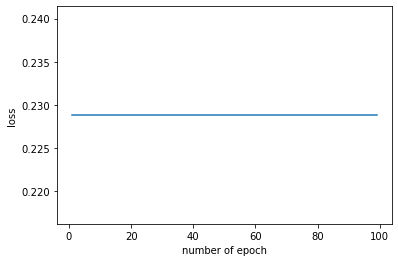

In [233]:
w,b=gradient_descent(X_transform,y_train)

In [234]:
print("weight:",w)
print("bias:",b)

weight: [0.02532093]
bias: 4.1910961022344475


In [235]:
def predict(inp):
    y_lst=[]
    for i in range(len(inp)):
        y_lst.append(w@inp[i]+b)
    return np.array(y_lst)

In [236]:
X_test=sc.fit_transform(x_test)
y_pred=predict(X_test)

In [237]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("R2 score : %.3f" % r2_score(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, y_pred)))

R2 score : 0.002
MSE: 0.229
RMSE: 0.479
MAE: 0.561


### For P3 (Size)

In [238]:
def predicted_y(weight,x,intercept):
    y_lst=[]
    for i in range(len(x)):
        y_lst.append(weight@x[i]+intercept)
    return np.array(y_lst)
    

# linear loss
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

#derivative of loss w.r.t weight
def dldw(x,y,y_predicted):
    s=0
    n=len(y)
    for i in range(n):
        s+=-x[i]*(y[i]-y_predicted[i])
    return (2/n)*s
    

# derivative of loss w.r.t bias
def dldb(y,y_predicted):
    n=len(y)
    s=0
    for i in range(len(y)):
        s+=-(y[i]-y_predicted[i])
    return (2/n) * s

# gradient function
def gradient_descent(x,y):
    weight_vector=np.random.randn(x.shape[1])
    intercept=0
    epoch = 100
    n = len(x)
    linear_loss=[]
    learning_rate =0.1
    for i in range(epoch):
        
        
        y_predicted = predicted_y(weight_vector,x,intercept)
        
        weight_vector = weight_vector - learning_rate *dldw(x,y,y_predicted) 
        
        
        intercept = intercept - learning_rate * dldb(y,y_predicted)
        linear_loss.append(loss(y,y_predicted))
        
    plt.plot(np.arange(1,epoch),linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")
    
    return weight_vector,intercept

In [239]:
x_sr = train_data.iloc[:, 3:4].values
y = train_data.iloc[:, 1].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sr, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_transform=sc.fit_transform(x_train)

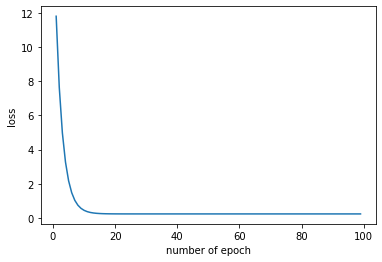

In [240]:
w,b=gradient_descent(X_transform,y_train)

In [241]:
print("weight:",w)
print("bias:",b)

weight: [0.04233722]
bias: 4.191096101380706


In [242]:
def predict(inp):
    y_lst=[]
    for i in range(len(inp)):
        y_lst.append(w@inp[i]+b)
    return np.array(y_lst)

In [243]:
X_test=sc.fit_transform(x_test)
y_pred=predict(X_test)

In [244]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("R2 score : %.3f" % r2_score(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, y_pred)))

R2 score : 0.006
MSE: 0.228
RMSE: 0.478
MAE: 0.559


### For P1+P2 (Reviews and Installs)

In [245]:
def predicted_y(weight,x,intercept):
    y_lst=[]
    for i in range(len(x)):
        y_lst.append(weight@x[i]+intercept)
    return np.array(y_lst)
    

# linear loss
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

#derivative of loss w.r.t weight
def dldw(x,y,y_predicted):
    s=0
    n=len(y)
    for i in range(n):
        s+=-x[i]*(y[i]-y_predicted[i])
    return (2/n)*s
    

# derivative of loss w.r.t bias
def dldb(y,y_predicted):
    n=len(y)
    s=0
    for i in range(len(y)):
        s+=-(y[i]-y_predicted[i])
    return (2/n) * s

# gradient function
def gradient_descent(x,y):
    weight_vector=np.random.randn(x.shape[1])
    intercept=0
    epoch = 500
    n = len(x)
    linear_loss=[]
    learning_rate = 0.05

    for i in range(epoch):
        
        
        y_predicted = predicted_y(weight_vector,x,intercept)
        
        weight_vector = weight_vector - learning_rate *dldw(x,y,y_predicted) 
        
        
        intercept = intercept - learning_rate * dldb(y,y_predicted)
        linear_loss.append(loss(y,y_predicted))
        
    plt.plot(np.arange(1,epoch),linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")
    
    return weight_vector,intercept

In [246]:
x_sr = train_data.iloc[:, 2:5:2].values
y = train_data.iloc[:, 1].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sr, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_transform=sc.fit_transform(x_train)

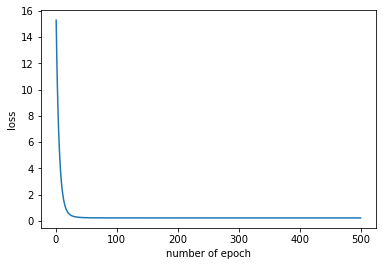

In [247]:
w,b=gradient_descent(X_transform,y_train)

In [248]:
print("weight:",w)
print("bias:",b)

weight: [0.03180212 0.00595169]
bias: 4.191096102234443


In [249]:
def predict(inp):
    y_lst=[]
    for i in range(len(inp)):
        y_lst.append(w@inp[i]+b)
    return np.array(y_lst)

In [250]:
X_test=sc.fit_transform(x_test)
y_pred=predict(X_test)

In [251]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("R2 score : %.3f" % r2_score(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, y_pred)))

R2 score : 0.003
MSE: 0.229
RMSE: 0.479
MAE: 0.560


### For All Predictors

In [252]:
def predicted_y(weight,x,intercept):
    y_lst=[]
    for i in range(len(x)):
        y_lst.append(weight@x[i]+intercept)
    return np.array(y_lst)
    

# linear loss
def loss(y,y_predicted):
    n=len(y)
    s=0
    for i in range(n):
        s+=(y[i]-y_predicted[i])**2
    return (1/n)*s

#derivative of loss w.r.t weight
def dldw(x,y,y_predicted):
    s=0
    n=len(y)
    for i in range(n):
        s+=-x[i]*(y[i]-y_predicted[i])
    return (2/n)*s
    

# derivative of loss w.r.t bias
def dldb(y,y_predicted):
    n=len(y)
    s=0
    for i in range(len(y)):
        s+=-(y[i]-y_predicted[i])
    return (2/n) * s

# gradient function
def gradient_descent(x,y):
    weight_vector=np.random.randn(x.shape[1])
    intercept=0
    epoch = 100
    n = len(x)
    linear_loss=[]
    learning_rate = 0.01

    for i in range(epoch):
        
        
        y_predicted = predicted_y(weight_vector,x,intercept)
        
        weight_vector = weight_vector - learning_rate *dldw(x,y,y_predicted) 
        
        
        intercept = intercept - learning_rate * dldb(y,y_predicted)
        linear_loss.append(loss(y,y_predicted))
        
    plt.plot(np.arange(1,epoch),linear_loss[1:])
    plt.xlabel("number of epoch")
    plt.ylabel("loss")
    
    return weight_vector,intercept

In [253]:
x_sr = train_data.iloc[:, 2:].values
y = train_data.iloc[:, 1].values

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_sr, y, test_size=0.3, random_state=0)

from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_transform=sc.fit_transform(x_train)

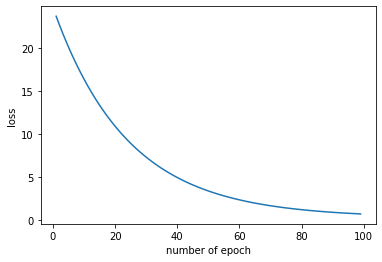

In [254]:
w,b=gradient_descent(X_transform,y_train)

In [255]:
print("weight:",w)
print("bias:",b)

weight: [ 0.32829894 -0.11709066 -0.24124644 -0.21384387 -0.04733088 -0.07408218
 -0.14475387]
bias: 3.635274798443884


In [256]:
def predict(inp):
    y_lst=[]
    for i in range(len(inp)):
        y_lst.append(w@inp[i]+b)
    return np.array(y_lst)

In [257]:
X_test=sc.fit_transform(x_test)
y_pred=predict(X_test)

In [258]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt
print("R2 score : %.3f" % r2_score(y_test, y_pred))
print("MSE: %.3f" % mean_squared_error(y_test, y_pred))
print("RMSE: %.3f" % sqrt(mean_squared_error(y_test, y_pred)))
print("MAE: %.3f" % sqrt(mean_absolute_error(y_test, y_pred)))

R2 score : -1.860
MSE: 0.658
RMSE: 0.811
MAE: 0.825


# Feature Selection and AIC,BIC Calculation

In [259]:
X=train_data.drop(columns='Rating',axis=1)
Y=train_data.Rating

In [260]:
MLR_reg = linear_model.LinearRegression(fit_intercept=True)

In [261]:
def fit_linear_reg(X,Y):
    MLR_reg.fit(X,Y)
    RSS=mean_squared_error(Y,MLR_reg.predict(X))*len(Y)
    R_squared=MLR_reg.score(X,Y)
    return RSS , R_squared

In [262]:
from tqdm import tnrange, tqdm_notebook
k=5
RSS_list, R_squared_list, feature_list=[],[],[]
numb_features=[]

for k in tnrange(1,len(X.columns)+1,desc='Loop...'):
    for combo in itertools.combinations(X.columns,k):
        tmp_result=fit_linear_reg(X[list(combo)],Y)
        RSS_list.append(tmp_result[0])
        R_squared_list.append(tmp_result[1])
        feature_list.append(combo)
        numb_features.append(len(combo))
        
df=pd.DataFrame({'numb_features':numb_features,'RSS':RSS_list,'R_squared':R_squared_list,'features':feature_list})        

C:\Users\dell\AppData\Local\Temp/ipykernel_2412/884055379.py:6: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for k in tnrange(1,len(X.columns)+1,desc='Loop...'):


Loop...:   0%|          | 0/8 [00:00<?, ?it/s]

In [263]:
df

,numb_features,RSS,R_squared,features
0,1,2485.510022,0.001296,"(Category,)"
1,1,2477.032017,0.004703,"(Reviews,)"
2,1,2470.532218,0.007315,"(Size,)"
3,1,2482.030424,0.002694,"(Installs,)"
4,1,2483.811883,0.001979,"(Type,)"
...,...,...,...,...
250,7,2454.471122,0.013768,"(Category, Reviews, Size, Type, Price, Content..."
251,7,2462.215696,0.010656,"(Category, Reviews, Installs, Type, Price, Con..."
252,7,2455.908250,0.013191,"(Category, Size, Installs, Type, Price, Conten..."
253,7,2454.259247,0.013853,"(Reviews, Size, Installs, Type, Price, Content..."


In [264]:
##Finding Best subsets for each number of features

df_min=df[df.groupby('numb_features')['RSS'].transform(min)==df['RSS']]
df_max=df[df.groupby('numb_features')['R_squared'].transform(max)==df['R_squared']]
display(df_min.head(3))
display(df_max.head(3))

,numb_features,RSS,R_squared,features
2,1,2470.532218,0.007315,"(Size,)"
22,2,2464.873957,0.009588,"(Size, Type)"
78,3,2461.173653,0.011075,"(Size, Type, Genres)"


,numb_features,RSS,R_squared,features
2,1,2470.532218,0.007315,"(Size,)"
22,2,2464.873957,0.009588,"(Size, Type)"
78,3,2461.173653,0.011075,"(Size, Type, Genres)"


In [265]:
#Addingg columns to the dataframe with RSS and R squared values of the best subset
df['min_RSS']=df.groupby('numb_features')['RSS'].transform(min)
df['max_R_squared']=df.groupby('numb_features')['R_squared'].transform(max)

In [266]:
df.head()

,numb_features,RSS,R_squared,features,min_RSS,max_R_squared
0,1,2485.510022,0.001296,"(Category,)",2470.532218,0.007315
1,1,2477.032017,0.004703,"(Reviews,)",2470.532218,0.007315
2,1,2470.532218,0.007315,"(Size,)",2470.532218,0.007315
3,1,2482.030424,0.002694,"(Installs,)",2470.532218,0.007315
4,1,2483.811883,0.001979,"(Type,)",2470.532218,0.007315


Text(0.5, 1.0, 'R_squared-Best Subset selection')

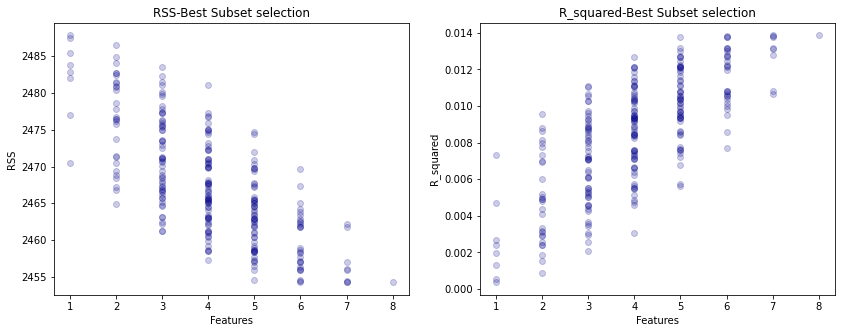

In [267]:
#Plotting the best subset selection process
fig=plt.figure(figsize=(14,5))
ax=fig.add_subplot(1,2,1)
ax.scatter(df.numb_features,df.RSS,alpha=0.2,color='darkblue')
ax.set_xlabel('Features')
ax.set_ylabel('RSS')
ax.set_title('RSS-Best Subset selection')

ax=fig.add_subplot(1,2,2)
ax.scatter(df.numb_features,df.R_squared,alpha=0.2,color='darkblue')
ax.set_xlabel('Features')
ax.set_ylabel('R_squared')
ax.set_title('R_squared-Best Subset selection')

In [268]:
remaining_features=list(X.columns.values)
features=[]
RSS_list,R_squared_list=[np.inf],[np.inf]
features_list=dict()

for i in range(1,k+1):
    best_RSS=np.inf
    for combo in itertools.combinations(remaining_features,1):
        RSS=fit_linear_reg(X[list(combo)+features], Y)
        if RSS[0]<best_RSS:
            best_RSS=RSS[0]
            best_R_squared=RSS[1]
            best_feature=combo[0]
    features.append(best_feature)
    remaining_features.remove(best_feature)
    
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i]=features.copy()

In [269]:
print('Forward stepwise subset selection')
print('Number of features |', 'Features |', "RSS")
display([(i,features_list[i],round(RSS_list[i])) for i in range(1,8)])

Forward stepwise subset selection
Number of features | Features | RSS


[(1, ['Size'], 2471),
 (2, ['Size', 'Type'], 2465),
 (3, ['Size', 'Type', 'Genres'], 2461),
 (4, ['Size', 'Type', 'Genres', 'Reviews'], 2457),
 (5, ['Size', 'Type', 'Genres', 'Reviews', 'Price'], 2455),
 (6, ['Size', 'Type', 'Genres', 'Reviews', 'Price', 'Installs'], 2454),
 (7,
  ['Size', 'Type', 'Genres', 'Reviews', 'Price', 'Installs', 'Category'],
  2454)]

In [270]:
df1=pd.concat([pd.DataFrame({'features':features_list}),pd.DataFrame({'RSS':RSS_list, 'R_squared':R_squared_list})],axis=1,join='inner')
df1['numb_features']=df1.index

In [271]:
df1

,features,RSS,R_squared,numb_features
1,[Size],2470.532218,0.007315,1
2,"[Size, Type]",2464.873957,0.009588,2
3,"[Size, Type, Genres]",2461.173653,0.011075,3
4,"[Size, Type, Genres, Reviews]",2457.235523,0.012657,4
5,"[Size, Type, Genres, Reviews, Price]",2454.508196,0.013753,5
6,"[Size, Type, Genres, Reviews, Price, Installs]",2454.259553,0.013853,6
7,"[Size, Type, Genres, Reviews, Price, Installs,...",2454.231652,0.013864,7
8,"[Size, Type, Genres, Reviews, Price, Installs,...",2454.231461,0.013864,8


In [272]:
##Computing the c_p, AIC, BIC and adjusted R_square
m=len(Y)
p=8
hat_sigma_squared=(1/(m-p-1))*min(df1['RSS'])

df1['C_p']=(1/m)*(df1['RSS']+2*df1['numb_features']* hat_sigma_squared)
df1['AIC']=(1/(m*hat_sigma_squared))* (df1['RSS']+2*df1['numb_features']*hat_sigma_squared)
df1['BIC']=(1/(m*hat_sigma_squared))* (df1['RSS']+np.log(m) *df1['numb_features']*hat_sigma_squared)
df1['R_squared_adj']=1-((1-df1['R_squared'])*(m-1)/(m-df1['numb_features']-1))
df1

,features,RSS,R_squared,numb_features,C_p,AIC,BIC,R_squared_adj
1,[Size],2470.532218,0.007315,1,0.227972,1.005991,1.006663,0.007223
2,"[Size, Type]",2464.873957,0.009588,2,0.227492,1.003871,1.005217,0.009405
3,"[Size, Type, Genres]",2461.173653,0.011075,3,0.227192,1.002550,1.004567,0.010801
4,"[Size, Type, Genres, Reviews]",2457.235523,0.012657,4,0.226870,1.001131,1.003821,0.012293
5,"[Size, Type, Genres, Reviews, Price]",2454.508196,0.013753,5,0.226661,1.000205,1.003568,0.013298
6,"[Size, Type, Genres, Reviews, Price, Installs]",2454.259553,0.013853,6,0.226679,1.000288,1.004324,0.013307
7,"[Size, Type, Genres, Reviews, Price, Installs,...",2454.231652,0.013864,7,0.226719,1.000461,1.005170,0.013227
8,"[Size, Type, Genres, Reviews, Price, Installs,...",2454.231461,0.013864,8,0.226761,1.000646,1.006027,0.013136


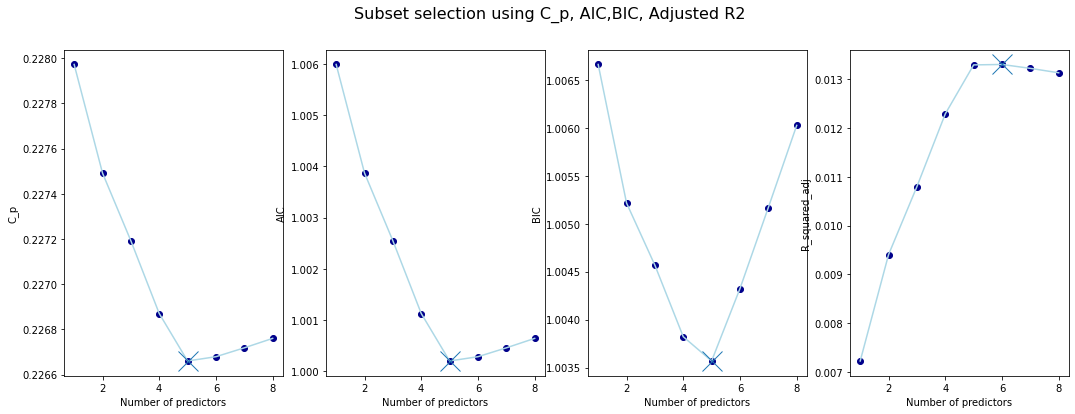

In [273]:
#Plotting the computed values as a function of number of features
variables=['C_p', 'AIC','BIC', 'R_squared_adj']
fig=plt.figure(figsize=(18,6))

for i,v in enumerate(variables):
    ax=fig.add_subplot(1,4,i+1)
    ax.plot(df1['numb_features'],df1[v],color='lightblue')
    ax.scatter(df1['numb_features'],df1[v],color='darkblue')
    if v=='R_squared_adj':
        ax.plot(df1[v].idxmax(),df1[v].max(), marker='x',markersize=20)
    else:
        ax.plot(df1[v].idxmin(),df1[v].min(), marker='x',markersize=20)
        
    ax.set_xlabel('Number of predictors')
    ax.set_ylabel(v)
fig.suptitle('Subset selection using C_p, AIC,BIC, Adjusted R2',fontsize=16)
plt.show()